# Setting up Spark Environment

In [1]:


from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("Social Commerce").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1000m").\
        config("spark.executor.cores", "2").\
        config("spark.cores.max", "6").\
        getOrCreate()



23/05/21 00:14:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Install necessary packages
#!pip install pyspark==3.2.0

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Create SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()

## Libraries and Modules Installation

In [3]:
#Spark
from pyspark.sql import functions as sparkf
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from functools import reduce

## Data Collection

In [4]:
#! apt-get update
#! apt-get install wget -y

In [5]:
#! wget https://storage.googleapis.com/22may2023/testfunnel.csv
#! wget https://storage.googleapis.com/aekanunlab/funneldata.zip

In [6]:
#! apt-get update
#! apt-get install unzip -y

In [7]:
#! unzip funneldata.zip

In [8]:
#! head -3 testfunnel.csv
! head -3 000000000000

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [9]:
#! wc -l testfunnel.csv
! wc -l 000000000000

917815 000000000000


In [10]:
raw_df = spark.read.option('header','true')\
.option("inferSchema" , "true")\
.format('csv').load('./000000000000')

# 1. Business Understanding

**ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะซื้อหรือไม่ซื้อสินค้าหรือไม่ (Binary Classification)**

In [11]:
business_requiredCol_list = [x for x in raw_df.columns]

In [12]:
customerBehaviorCol_list = [x for x in raw_df.columns \
         if ((x != 'sourceKeyword')&(x != 'fullVisitorId')&(x != 'isVideoAd')&(x != 'date')\
             &(x != 'isTrueDirect')&(x != 'hitHour')&(x != 'hitMin')&(x != 'isClick')\
             &(x != 'productListName')&(x != 'isImpression')&(x != 'sessionQualityDim')&(x != 'timeOnScreen')\
             &(x != 'hitReferer')&(x != 'medium')&(x != 'hitType'))]

# 2. Data Understanding

### Previewing Data

In [13]:
raw_df.count()

917814

In [14]:
len(raw_df.columns)

24

In [15]:
raw_df.sample(0.001).toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,915,916,917,918,919,920,921,922,923,924
source,google,google,(direct),(direct),google,(direct),google,google,google,(direct),...,youtube.com,google,youtube.com,(direct),dfa,youtube.com,(direct),google,google,google
isTrueDirect,True,True,True,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
sourceKeyword,(not provided),(not provided),None,None,(not provided),None,(not provided),(not provided),youtube merch,None,...,None,(not provided),None,None,None,None,None,(not provided),(not provided),(not provided)
medium,organic,organic,(none),(none),organic,(none),organic,organic,cpc,(none),...,referral,organic,referral,(none),cpm,referral,(none),organic,organic,organic
isVideoAd,None,None,None,False,None,None,None,None,False,None,...,None,None,None,None,None,None,None,None,None,None
fullVisitorId,4988612949713423910,4988612949713423910,4992317753515158805,4992772271736200092,4992825232100275341,4993450863033496114,4993876737142975317,4994319889838750000,4995251874694255755,4995356988620593823,...,548102970131289821,5482759080804282482,5482820136547373575,5484144360559795874,5484144360559795874,5484991115522820610,548545757162990083,5485988366687211191,5486542684848997564,5486542684848997564
visitId,1489617360,1490043910,1496175863,1478983581,1493188415,1485313789,1493496187,1472164694,1495500364,1481560042,...,1488334035,1471792462,1483509740,1479231404,1481143955,1486249397,1501625147,1489295209,1474066322,1474066322
date,20170315,20170320,20170530,20161112,20170425,20170124,20170429,20160825,20170522,20161212,...,20170228,20160821,20170103,20161115,20161207,20170204,20170801,20170311,20160916,20160916
newVisits,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
hitReferer,None,None,None,None,https://www.google.com/,None,https://www.google.lt/,None,None,None,...,None,None,None,None,None,None,None,https://www.google.co.in/,None,None


In [16]:
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransac

### Exploratory Data Analysis - Univariate Analysis



In [17]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,917814,None,None,(direct),youtube.com
sourceKeyword,322031,None,None,(Remarketing/Content targeting),yyoutubr
medium,917814,None,None,(none),referral
fullVisitorId,917814,4.7679506549928141E18,1.42707561410277837E18,514359656957582,5487531102128447544
visitId,917814,1.4828991660307045E9,9692290.975135243,1470037326,1501656575
date,917814,2.0165139267192483E7,4699.035428253378,20160801,20170801
newVisits,647359,1.0,0.0,1,1
hitReferer,119959,None,None,http://googleads.g.doubleclick.net/pagead/ads?...,https://youtube.com/yt/about/copyright/
hitType,917814,None,None,EVENT,PAGE


In [18]:
from pyspark.sql.types import IntegerType, FloatType

numeric_columns = []
non_numeric_columns = []

for col_name in raw_df.columns:
    # Check if the column type is numeric
    if isinstance(raw_df.schema[col_name].dataType, IntegerType) or isinstance(raw_df.schema[col_name].dataType, FloatType):
        numeric_columns.append(col_name)
    else:
        non_numeric_columns.append(col_name)

print(f"Numeric columns: {numeric_columns}")
print(f"Non-numeric columns: {non_numeric_columns}")


Numeric columns: ['visitId', 'date', 'newVisits', 'hitAction_type', 'hitNumber', 'hitHour', 'hitMin', 'timeMicroSec', 'sessionQualityDim', 'timeOnSite']
Non-numeric columns: ['source', 'isTrueDirect', 'sourceKeyword', 'medium', 'isVideoAd', 'fullVisitorId', 'hitReferer', 'hitType', 'v2ProductName', 'productListName', 'isClick', 'isImpression', 'timeOnScreen', 'totalTransactionRevenue']


In [19]:
numeric_columns

['visitId',
 'date',
 'newVisits',
 'hitAction_type',
 'hitNumber',
 'hitHour',
 'hitMin',
 'timeMicroSec',
 'sessionQualityDim',
 'timeOnSite']

In [20]:
non_numeric_columns

['source',
 'isTrueDirect',
 'sourceKeyword',
 'medium',
 'isVideoAd',
 'fullVisitorId',
 'hitReferer',
 'hitType',
 'v2ProductName',
 'productListName',
 'isClick',
 'isImpression',
 'timeOnScreen',
 'totalTransactionRevenue']

In [21]:
from pyspark.sql.functions import count, when, isnan, col
# Check for null values
raw_df.select(numeric_columns).select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                                       for c in raw_df.select(numeric_columns).columns]).toPandas().transpose()

,0
visitId,0
date,0
newVisits,270455
hitAction_type,0
hitNumber,0
hitHour,0
hitMin,0
timeMicroSec,0
sessionQualityDim,856032
timeOnSite,67305


In [22]:
raw_df.groupBy('sessionQualityDim').count().show()

## สังเกตว่า หลักการเรื่อง Imputation ด้วย Avg หรือ Agg.func. ไม่สามารถนำมาใช้ได้เสมอไป
## ลองคิดดูว่า หาก Avg('sessionQualityDim') แล้วได้ค่าหนึ่ง คำถามคือ ค่านั้นนำมาแทน null
## จริงหรือ?

+-----------------+------+
|sessionQualityDim| count|
+-----------------+------+
|               31|    45|
|               85|   250|
|               65|   211|
|               53|   366|
|               78|   134|
|               34|   269|
|               81|   427|
|               28|    89|
|               76|   492|
|               26|   180|
|               27|   128|
|               44|   596|
|               12|   451|
|               91|   148|
|               22|   189|
|               47|   184|
|             null|856032|
|                1| 28967|
|               52|    37|
|               13|   141|
+-----------------+------+
only showing top 20 rows



In [23]:
raw_df.groupBy('newVisits').count().show()

+---------+------+
|newVisits| count|
+---------+------+
|     null|270455|
|        1|647359|
+---------+------+



In [24]:
from pyspark.sql import functions as sparkf

noNull_df = raw_df.withColumn('newVisits',sparkf.when(sparkf.col('newVisits').isNull(),'NA')\
                  .otherwise(sparkf.col('newVisits')))\
                  .withColumn('sessionQualityDim',sparkf.when(sparkf.col('sessionQualityDim').isNull(),'NA')\
                  .otherwise(sparkf.col('sessionQualityDim')))\
                  .withColumn('timeOnSite',sparkf.when(sparkf.col('timeOnSite').isNull(),0)\
                  .otherwise(sparkf.col('timeOnSite')))\
                  .withColumn('totalTransactionRevenue',sparkf.when(sparkf.col('totalTransactionRevenue').isNull(),0)\
                  .otherwise(sparkf.col('totalTransactionRevenue')))

In [25]:
noNull_df.select(numeric_columns).select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                                       for c in noNull_df.select(numeric_columns).columns]).toPandas().transpose()

,0
visitId,0
date,0
newVisits,0
hitAction_type,0
hitNumber,0
hitHour,0
hitMin,0
timeMicroSec,0
sessionQualityDim,0
timeOnSite,0


In [26]:
### raw_df.printSchema()

In [27]:
### noNull_df.printSchema()

In [28]:
from pyspark.sql.types import IntegerType, FloatType

numeric_columns = []
non_numeric_columns = []

for col_name in noNull_df.columns:
    # Check if the column type is numeric
    if isinstance(noNull_df.schema[col_name].dataType, IntegerType) or isinstance(noNull_df.schema[col_name].dataType, FloatType):
        numeric_columns.append(col_name)
    else:
        non_numeric_columns.append(col_name)

print(f"Numeric columns: {numeric_columns}")
print(f"Non-numeric columns: {non_numeric_columns}")

Numeric columns: ['visitId', 'date', 'hitAction_type', 'hitNumber', 'hitHour', 'hitMin', 'timeMicroSec', 'timeOnSite']
Non-numeric columns: ['source', 'isTrueDirect', 'sourceKeyword', 'medium', 'isVideoAd', 'fullVisitorId', 'newVisits', 'hitReferer', 'hitType', 'v2ProductName', 'productListName', 'isClick', 'isImpression', 'sessionQualityDim', 'timeOnScreen', 'totalTransactionRevenue']


In [29]:
from pyspark.sql.functions import col

# Calculate Q1, Q3, and IQR for each numeric column
for col_name in numeric_columns:
    quantiles = raw_df.stat.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    # Filter values out of the (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR) range
    outliers = raw_df.filter((col(col_name) < Q1 - 1.5 * IQR) | (col(col_name) > Q3 + 1.5 * IQR))
    print(f"Column {col_name} has {outliers.count()} outliers")


Column visitId has 0 outliers


Column date has 0 outliers


Column hitAction_type has 63911 outliers


Column hitNumber has 107855 outliers


Column hitHour has 0 outliers


Column hitMin has 0 outliers


Column timeMicroSec has 108522 outliers


Column timeOnSite has 70879 outliers


In [30]:
from pyspark.sql.functions import log

# Initialize DataFrame
takeLog_df = noNull_df

# Loop through each numeric column and take log to fix skewness
for col in numeric_columns:
    takeLog_df = takeLog_df.withColumn(col, log(takeLog_df[col]))

# Check outliers
for col in numeric_columns:
    bounds = {
        c: dict(
            zip(["q1", "q3"], takeLog_df.approxQuantile(c, [0.25, 0.75], 0))
        )
        for c in [col]
    }

    for c in bounds:
        iqr = bounds[c]['q3'] - bounds[c]['q1']
        bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
        bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
        print(f"Column {c} has {takeLog_df.filter((takeLog_df[c] < bounds[c]['lower']) | (takeLog_df[c] > bounds[c]['upper'])).count()} outliers")


Column visitId has 0 outliers


Column date has 0 outliers


Column hitAction_type has 0 outliers


Column hitNumber has 122 outliers


Column hitHour has 57903 outliers


Column hitMin has 42814 outliers


Column timeMicroSec has 1471 outliers


Column timeOnSite has 8389 outliers


In [31]:
numeric_columns

['visitId',
 'date',
 'hitAction_type',
 'hitNumber',
 'hitHour',
 'hitMin',
 'timeMicroSec',
 'timeOnSite']

In [32]:
from pyspark.sql.functions import col

# สร้าง DataFrame ใหม่เพื่อจัดการ outlier
filtered_dfs = {}
filtered_dfs[numeric_columns[0]] = noNull_df

# ทำการกรอง outliers ออกจาก DataFrame
for idx, c in enumerate(numeric_columns[1:], start=1):
    # คำนวณ IQR
    Q1, Q3 = filtered_dfs[numeric_columns[idx-1]].approxQuantile(c, [0.25, 0.75], 0.05)
    IQR = Q3 - Q1

    # กำหนดระดับที่จะถือว่าเป็น outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # กรอง outliers ออกจาก DataFrame และสร้าง DataFrame ใหม่
    filtered_dfs[c] = filtered_dfs[numeric_columns[idx-1]].filter((col(c) >= lower_bound) & (col(c) <= upper_bound))

noOutlier_df = filtered_dfs[numeric_columns[-1]]

print(f"Number of rows after removing outliers: {noOutlier_df.count()}")


Number of rows after removing outliers: 612294


In [33]:
for a in business_requiredCol_list:
  raw_df.groupBy(a).count().orderBy('count',ascending = False).show()

+--------------------+------+
|              source| count|
+--------------------+------+
|            (direct)|502654|
|              google|320612|
|         youtube.com| 34750|
|            Partners|  9949|
|                 dfa|  8696|
|analytics.google.com|  6144|
|          google.com|  4537|
|    sites.google.com|  3866|
|siliconvalley.abo...|  3399|
|      m.facebook.com|  2283|
|        facebook.com|  2073|
|          reddit.com|  1978|
|     mail.google.com|  1833|
|                bing|  1543|
|           qiita.com|  1496|
|               yahoo|  1441|
|           quora.com|  1252|
|                t.co|   996|
|   groups.google.com|   950|
|      l.facebook.com|   517|
+--------------------+------+
only showing top 20 rows



+------------+------+
|isTrueDirect| count|
+------------+------+
|        null|580491|
|        true|337323|
+------------+------+



+--------------------+------+
|       sourceKeyword| count|
+--------------------+------+
|                null|595783|
|      (not provided)|296422|
|    6qEhsCssdK0z36ri| 12471|
|  Google Merchandise|  2529|
|    1hZbAqLCbjwfgOH7|  2273|
|google merchandis...|  2061|
|    category_l1==166|   457|
|(Remarketing/Cont...|   373|
|    1X4Me6ZKNV0zg-jV|   330|
|googlemerchandise...|   323|
|             youtube|   207|
|+google +merchand...|   201|
|        google merch|   198|
|         google stor|   171|
|       youtube merch|   169|
|+Google +Merchandise|   164|
|Google Merchandis...|   164|
|      +google +store|   162|
|             Youtube|   140|
|        google store|   121|
+--------------------+------+
only showing top 20 rows



+---------+------+
|   medium| count|
+---------+------+
|   (none)|502654|
|  organic|302345|
| referral| 72078|
|      cpc| 21580|
|affiliate|  9949|
|      cpm|  9136|
|(not set)|    72|
+---------+------+



+---------+------+
|isVideoAd| count|
+---------+------+
|     null|885422|
|    false| 32392|
+---------+------+



+-------------------+-----+
|      fullVisitorId|count|
+-------------------+-----+
|5456301402188625337| 3416|
|5208937953046059083| 2377|
|5399906287295745418| 2338|
|5310912563447452038| 1792|
|5370310992308515600| 1777|
|5143600689169444167| 1651|
|5217792392522047587| 1605|
|4998444590527389280| 1550|
|5479405825116961439| 1482|
|5174129705003851738| 1472|
|5341271361784611942| 1443|
|5305785224618680102| 1413|
|5423659711610895780| 1267|
|5002959687839673544| 1211|
|5128888224452873031| 1179|
|5315382266855883329| 1164|
|5457033415990547887| 1143|
| 506797253390432707| 1094|
|5391968741622668774| 1081|
|5031234556107572838| 1081|
+-------------------+-----+
only showing top 20 rows



+----------+-----+
|   visitId|count|
+----------+-----+
|1487093395| 1777|
|1472342843| 1306|
|1474845319|  995|
|1473902040|  986|
|1471629165|  950|
|1474799746|  924|
|1472479074|  920|
|1472343066|  919|
|1473468179|  913|
|1479842010|  867|
|1481587574|  817|
|1478550894|  793|
|1473022577|  790|
|1470432463|  786|
|1471836187|  781|
|1474775547|  779|
|1471884865|  775|
|1471752880|  773|
|1473181908|  755|
|1483021729|  753|
+----------+-----+
only showing top 20 rows



+--------+-----+
|    date|count|
+--------+-----+
|20160815| 8733|
|20160914| 8693|
|20160822| 8214|
|20160831| 7571|
|20160804| 7514|
|20160816| 7394|
|20160811| 7300|
|20160823| 6858|
|20160906| 6836|
|20160921| 6828|
|20160907| 6598|
|20160913| 6506|
|20160812| 6430|
|20160902| 6246|
|20160809| 6237|
|20160817| 6064|
|20160827| 6021|
|20160802| 5946|
|20160805| 5946|
|20160909| 5633|
+--------+-----+
only showing top 20 rows



+---------+------+
|newVisits| count|
+---------+------+
|        1|647359|
|     null|270455|
+---------+------+



+--------------------+------+
|          hitReferer| count|
+--------------------+------+
|                null|797855|
|https://www.googl...| 38623|
|https://www.googl...|  7437|
|https://www.youtu...|  7204|
|https://www.googl...|  6743|
|https://www.googl...|  3560|
|https://www.googl...|  2873|
|https://www.googl...|  2854|
|http://www.google...|  2356|
|https://www.googl...|  1912|
|https://www.googl...|  1909|
|https://www.googl...|  1573|
|https://www.googl...|  1329|
|https://www.googl...|  1200|
|https://www.googl...|   968|
|https://www.googl...|   967|
|https://www.googl...|   845|
|https://www.googl...|   839|
|https://www.googl...|   768|
|https://www.googl...|   764|
+--------------------+------+
only showing top 20 rows



+-------+------+
|hitType| count|
+-------+------+
|   PAGE|886585|
|  EVENT| 31229|
+-------+------+



+--------------+------+
|hitAction_type| count|
+--------------+------+
|             0|853903|
|             1| 22253|
|             2| 18313|
|             5| 12380|
|             3|  6200|
|             6|  3880|
|             4|   885|
+--------------+------+



+---------+------+
|hitNumber| count|
+---------+------+
|        1|128949|
|        3|104988|
|        2|101344|
|        4| 75432|
|        5| 54931|
|        6| 45212|
|        7| 40069|
|        8| 33037|
|        9| 28159|
|       10| 24166|
|       11| 21807|
|       12| 18867|
|       13| 17060|
|       14| 14858|
|       15| 13635|
|       16| 12554|
|       17| 11389|
|       18| 10054|
|       19|  9889|
|       20|  8821|
+---------+------+
only showing top 20 rows



+-------+-----+
|hitHour|count|
+-------+-----+
|     11|64196|
|     10|60383|
|     13|57946|
|     14|54553|
|     12|53822|
|      9|48343|
|      8|45227|
|     16|44962|
|     15|43676|
|     18|39950|
|     17|39395|
|     20|39173|
|      7|37065|
|     22|34531|
|     19|34193|
|     21|33678|
|     23|31245|
|      6|30732|
|      5|24574|
|      0|23328|
+-------+-----+
only showing top 20 rows



+------+-----+
|hitMin|count|
+------+-----+
|    21|16750|
|    43|16699|
|    58|16398|
|    23|16368|
|    52|16307|
|    41|16248|
|    30|16110|
|    57|16085|
|    54|16050|
|    36|15954|
|    56|15943|
|    28|15817|
|    53|15790|
|    26|15789|
|    20|15767|
|     9|15726|
|    35|15698|
|    40|15657|
|     6|15593|
|    42|15579|
+------+-----+
only showing top 20 rows



+------------+------+
|timeMicroSec| count|
+------------+------+
|           0|129394|
|       13598|    80|
|        9553|    80|
|       11300|    80|
|      374888|    80|
|       13027|    80|
|       11756|    79|
|       13796|    79|
|       17138|    73|
|           1|    72|
|       56918|    71|
|       33192|    70|
|        8860|    70|
|       32959|    70|
|       97580|    70|
|       11187|    69|
|       27902|    68|
|      534363|    68|
|        8751|    68|
|       10930|    68|
+------------+------+
only showing top 20 rows



+--------------------+-----+
|       v2ProductName|count|
+--------------------+-----+
|Google Men's 100%...|15365|
|22 oz YouTube Bot...|10277|
|YouTube Men's Sho...|10125|
|YouTube Custom De...| 9866|
|Google Men's 100%...| 9319|
|YouTube Men's Sho...| 9286|
|   YouTube Twill Cap| 9252|
|Google Men's 100%...| 9227|
|Electronics Acces...| 8507|
|YouTube Men's Sho...| 7970|
|YouTube Wool Heat...| 7968|
|Google Laptop and...| 7866|
|YouTube Leatheret...| 7599|
|Google Men's  Zip...| 7392|
| YouTube Trucker Hat| 7285|
|Google Men's Wate...| 7100|
|Suitcase Organize...| 7014|
|Google Men's 100%...| 6847|
|Google Alpine Sty...| 6602|
|Google Men's Vint...| 6565|
+--------------------+-----+
only showing top 20 rows



+----------------+------+
| productListName| count|
+----------------+------+
|        Category|847919|
|Related Products| 28085|
|       (not set)| 23657|
|  Search Results| 18153|
+----------------+------+



+-------+------+
|isClick| count|
+-------+------+
|   null|895561|
|   true| 22253|
+-------+------+



+------------+------+
|isImpression| count|
+------------+------+
|        true|853903|
|        null| 63911|
+------------+------+



+-----------------+------+
|sessionQualityDim| count|
+-----------------+------+
|             null|856032|
|                1| 28967|
|                2|  4177|
|                3|  1816|
|                4|  1641|
|                5|  1529|
|                7|   825|
|                6|   824|
|               68|   679|
|               19|   601|
|               44|   596|
|               10|   596|
|                8|   569|
|               77|   561|
|               76|   492|
|               80|   478|
|               54|   466|
|                9|   462|
|               12|   451|
|               62|   433|
+-----------------+------+
only showing top 20 rows



+------------+------+
|timeOnScreen| count|
+------------+------+
|        null|917814|
+------------+------+



+----------+-----+
|timeOnSite|count|
+----------+-----+
|      null|67305|
|        64| 2333|
|        67| 2264|
|        24| 2246|
|        55| 2230|
|        54| 2214|
|        13| 2212|
|        26| 2210|
|       106| 2188|
|       158| 2174|
|        87| 2120|
|        56| 2120|
|        90| 2119|
|        38| 2117|
|        35| 2113|
|      2469| 2099|
|        86| 2070|
|        52| 2060|
|       215| 2045|
|       169| 2026|
+----------+-----+
only showing top 20 rows



+-----------------------+------+
|totalTransactionRevenue| count|
+-----------------------+------+
|                   null|847514|
|              186860000|   950|
|              220520000|   920|
|              681400000|   817|
|              192440000|   786|
|               81980000|   704|
|              108630000|   671|
|               32950000|   652|
|               79150000|   644|
|              355970000|   626|
|              208640000|   583|
|               80060000|   579|
|              127380000|   577|
|               54000000|   569|
|              150340000|   565|
|              101940000|   556|
|               29980000|   540|
|              216630000|   524|
|              307740000|   522|
|               28980000|   511|
+-----------------------+------+
only showing top 20 rows



In [34]:
raw_df.groupBy('hitAction_type').count().orderBy('hitAction_type').show()

+--------------+------+
|hitAction_type| count|
+--------------+------+
|             0|853903|
|             1| 22253|
|             2| 18313|
|             3|  6200|
|             4|   885|
|             5| 12380|
|             6|  3880|
+--------------+------+



In [35]:
raw_df.groupBy('isTrueDirect').count().show()

+------------+------+
|isTrueDirect| count|
+------------+------+
|        null|580491|
|        true|337323|
+------------+------+



In [36]:
raw_df.groupBy('medium').count().show()

+---------+------+
|   medium| count|
+---------+------+
|   (none)|502654|
|      cpc| 21580|
| referral| 72078|
|  organic|302345|
|affiliate|  9949|
|(not set)|    72|
|      cpm|  9136|
+---------+------+



In [37]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,917814,None,None,(direct),youtube.com
sourceKeyword,322031,None,None,(Remarketing/Content targeting),yyoutubr
medium,917814,None,None,(none),referral
fullVisitorId,917814,4.7679506549928141E18,1.42707561410277811E18,514359656957582,5487531102128447544
visitId,917814,1.4828991660307045E9,9692290.975135246,1470037326,1501656575
date,917814,2.0165139267192483E7,4699.035428253388,20160801,20170801
newVisits,647359,1.0,0.0,1,1
hitReferer,119959,None,None,http://googleads.g.doubleclick.net/pagead/ads?...,https://youtube.com/yt/about/copyright/
hitType,917814,None,None,EVENT,PAGE


In [38]:
df = raw_df.select(['hitAction_type','hitHour','hitMin','productListName','hitType']).toPandas()

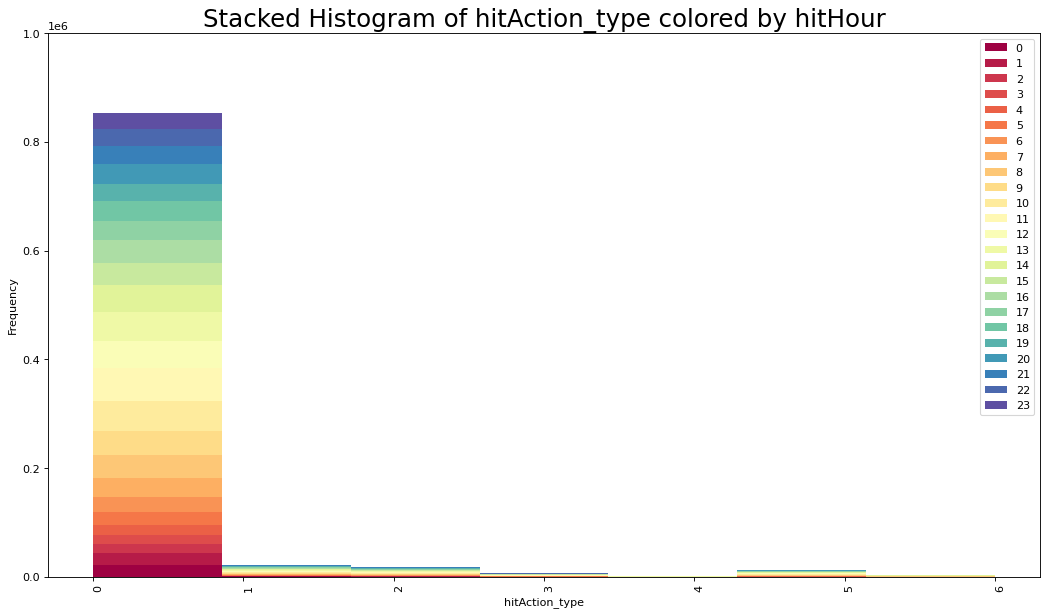

In [39]:
# Initialize parameters
x_var = 'hitAction_type'
groupby_var = 'hitHour'

# Group data by the variable of interest
df_grouped = df.groupby(groupby_var)

# Extract the values of x_var for each group
grouped_values = [group[x_var].values.tolist() for _, group in df_grouped]

# Define colors for each group
colors = [plt.cm.Spectral(i/float(len(grouped_values)-1)) for i in range(len(grouped_values))]

# Create a figure
plt.figure(figsize=(16,9), dpi=80)

# Create a stacked histogram
n, bins, patches = plt.hist(grouped_values, df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(grouped_values)])

# Add a legend
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(grouped_values)])})

# Add title and labels
plt.title(f"Stacked Histogram of {x_var} colored by {groupby_var}", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")

# Set the range of y-axis
plt.ylim(0, 1000000)

# Get unique values of x_var
unique_x_var = np.unique(df[x_var]).tolist()

# Use arange to generate ticks locations
bins = np.arange(len(unique_x_var))

# Set the labels of x-axis
plt.xticks(ticks=bins, labels=unique_x_var, rotation=90, horizontalalignment='left')


# Display the plot
plt.show()


(array([ 40.,   0.,   6.,  50.,  40.,  52.,  86., 166., 298., 156., 296.,
        378., 362., 302., 258., 204., 214., 176., 314., 230., 104.,  84.,
         40.,  24.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

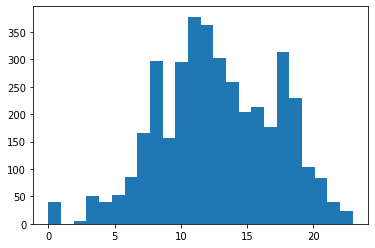

In [40]:
### แสดงการซื้อ (hitAction_type = 6) แจงแจงตามช่วงเวลา

bins, counts = raw_df.select('hitHour') \
.filter(raw_df.hitAction_type == 6).rdd.flatMap(lambda x: x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([22011., 20836., 17807., 16511., 17866., 23204., 28773., 34309.,
        41773., 45066., 55886., 59403., 49586., 53460., 50273., 40598.,
        41683., 36184., 36316., 31854., 36670., 31523., 32674., 29637.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

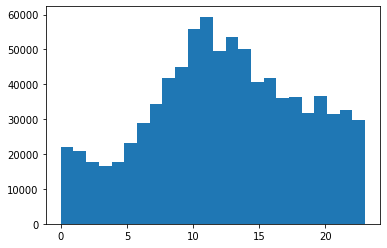

In [41]:
### แสดงการไม่ซื้อ (hitAction_type = 0) แจงแจงตามช่วงเวลา

bins, counts = raw_df.select('hitHour') \
.filter(raw_df.hitAction_type == 0).rdd.flatMap(lambda x: x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=counts)

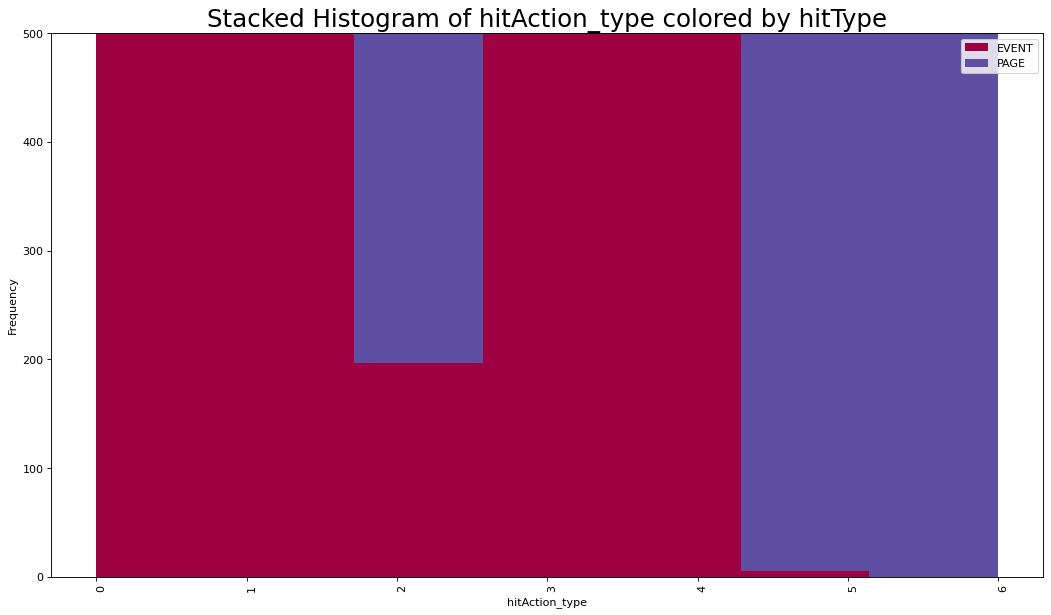

In [42]:
# Initialize parameters
x_var = 'hitAction_type'
groupby_var = 'hitType'

# Group data by the variable of interest
df_grouped = df.groupby(groupby_var)

# Extract the values of x_var for each group
grouped_values = [group[x_var].values.tolist() for _, group in df_grouped]

# Define colors for each group
colors = [plt.cm.Spectral(i/float(len(grouped_values)-1)) for i in range(len(grouped_values))]

# Create a figure
plt.figure(figsize=(16,9), dpi=80)

# Create a stacked histogram
n, bins, patches = plt.hist(grouped_values, df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(grouped_values)])

# Add a legend
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(grouped_values)])})

# Add title and labels
plt.title(f"Stacked Histogram of {x_var} colored by {groupby_var}", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")

# Set the range of y-axis
plt.ylim(0, 500)

# Get unique values of x_var
unique_x_var = np.unique(df[x_var]).tolist()

# Use arange to generate ticks locations
bins = np.arange(len(unique_x_var))

# Set the labels of x-axis
plt.xticks(ticks=bins, labels=unique_x_var, rotation=90, horizontalalignment='left')


# Display the plot
plt.show()


### Finding out partial duplicated records - Spurious Patterns

*โค้ดด้านล่างแสดงให้เห็นว่า มีลูกค้ากี่ราย*

In [43]:
raw_df.select(sparkf.countDistinct('fullVisitorId').alias('num_unique_user')).show()

+---------------+
|num_unique_user|
+---------------+
|          18006|
+---------------+



*โค้ดด้านล่างแสดงให้เห็นว่า ลูกค้าแต่ละราย (fullVisitorId) ที่เข้ามาได้หลายครั้ง (visitId) นั้นเกิด Hit ได้ตั้งแต่ 1 ครั้งขึ้นไป*

In [44]:
sessionWindow = W.partitionBy('fullVisitorId','visitId').orderBy(sparkf.col("hitNumber").cast("long"))\
                 .rangeBetween(-sys.maxsize, sys.maxsize)

In [45]:
allHit = sparkf.expr("count('hitNumber')")

In [46]:
raw_df.withColumn('numHit',allHit.over(sessionWindow))\
.select('fullVisitorId','visitId','numHit')\
.distinct().orderBy('fullVisitorId','visitId').show(7)

23/05/21 00:18:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+----------+------+
|   fullVisitorId|   visitId|numHit|
+----------------+----------+------+
| 514359656957582|1481535186|    24|
| 526704849855859|1492044399|    12|
|5046942961392781|1486511444|    60|
|5046942961392781|1486514836|    12|
|5123065735856055|1470410433|    84|
|5134451956558008|1486960913|    12|
|5134451956558008|1486964401|    12|
+----------------+----------+------+
only showing top 7 rows



*โค้ดด้านล่าง เป็นการ cross-check ว่าการคำนวนข้างบนนั้นถูกต้องแล้ว*

In [47]:
raw_df.filter((sparkf.col('fullVisitorId') == '4991536060599177108')&(sparkf.col('VisitId') == '1495501367'))\
.count()

12

*โค้ดด้านล่างแสดงให้เห็นว่า บาง visitId เท่านั้นนั้นที่มี hitAction_type เป็นเลข 6*

In [48]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter(sparkf.col('sum_hitAction_type_6')>=1)\
      .select(['fullVisitorId','visitId','sum_hitAction_type_6'])\
      .distinct().orderBy('fullVisitorId','visitId').show()

+------------------+----------+--------------------+
|     fullVisitorId|   visitId|sum_hitAction_type_6|
+------------------+----------+--------------------+
| 52868681653220057|1487247308|                   6|
| 52947395050573230|1473344657|                   4|
| 53866968780969645|1481914028|                   2|
|500766381427960566|1489605660|                   6|
|500771270741221130|1481728507|                   8|
|500926353574528949|1491191147|                   6|
|502027330594674519|1488479930|                   2|
|502427268661784166|1475681795|                   4|
|507378123137078709|1492017734|                  12|
|512376512516526849|1484413414|                   2|
|512988788718016553|1494940948|                   4|
|513403330506317388|1484058394|                   6|
|513403330506317388|1488427898|                   4|
|514366605460721708|1481841909|                   6|
|514478324726152361|1480456502|                   4|
|514517908760071241|1485384182|               

*โค้ดด้านล่าง เป็นการ cross-check ว่าการคำนวนข้างบนนั้นถูกต้องแล้ว*

In [49]:
raw_df.filter(sparkf.col('totalTransactionRevenue') >=0)\
.groupBy('fullVisitorId','visitId').count().alias('numHit').orderBy('fullVisitorId','visitId').show()

+------------------+----------+-----+
|     fullVisitorId|   visitId|count|
+------------------+----------+-----+
| 52868681653220057|1487247308|  102|
| 52947395050573230|1473344657|   43|
| 53866968780969645|1481914028|   97|
|500766381427960566|1489605660|  136|
|500771270741221130|1481728507|  162|
|500926353574528949|1491191147|   39|
|502027330594674519|1488479930|   17|
|502427268661784166|1475681795|  158|
|507378123137078709|1492017734|  172|
|512376512516526849|1484413414|   67|
|512988788718016553|1494940948|   30|
|513403330506317388|1484058394|  119|
|513403330506317388|1488427898|   42|
|514366605460721708|1481841909|   18|
|514478324726152361|1480456502|   46|
|514517908760071241|1485384182|   25|
|515195001502319520|1480385724|  177|
|515770511624914543|1493699819|   71|
|515770511624914543|1494428047|   70|
|516734366347147622|1478384303|  192|
+------------------+----------+-----+
only showing top 20 rows



In [50]:
raw_df.filter(sparkf.col('hitAction_type')==6)\
      .select('fullVisitorId','visitId').groupBy('fullVisitorId','visitId').count()\
      .orderBy('fullVisitorId','visitId').show()

+------------------+----------+-----+
|     fullVisitorId|   visitId|count|
+------------------+----------+-----+
| 52868681653220057|1487247308|    6|
| 52947395050573230|1473344657|    4|
| 53866968780969645|1481914028|    2|
|500766381427960566|1489605660|    6|
|500771270741221130|1481728507|    8|
|500926353574528949|1491191147|    6|
|502027330594674519|1488479930|    2|
|502427268661784166|1475681795|    4|
|507378123137078709|1492017734|   12|
|512376512516526849|1484413414|    2|
|512988788718016553|1494940948|    4|
|513403330506317388|1484058394|    6|
|513403330506317388|1488427898|    4|
|514366605460721708|1481841909|    6|
|514478324726152361|1480456502|    4|
|514517908760071241|1485384182|    2|
|515195001502319520|1480385724|    8|
|515770511624914543|1493699819|    4|
|515770511624914543|1494428047|    4|
|516734366347147622|1478384303|    4|
+------------------+----------+-----+
only showing top 20 rows



In [51]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter((sparkf.col('fullVisitorId') == '4995924842281653133')&(sparkf.col('VisitId') == '1486131356'))\
      .select(['fullVisitorId','visitId','hitNumber','timeMicroSec','hitAction_type'\
               ,'numHit','hitAction_type_6','sum_hitAction_type_6'])\
      .orderBy('hitNumber').show()

+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|      fullVisitorId|   visitId|hitNumber|timeMicroSec|hitAction_type|numHit|hitAction_type_6|sum_hitAction_type_6|
+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|  

In [52]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter((sparkf.col('fullVisitorId') == '4988683855814257726')&(sparkf.col('VisitId') == '1492045051'))\
      .select(['fullVisitorId','visitId','hitNumber','timeMicroSec','hitAction_type'\
               ,'numHit','hitAction_type_6','sum_hitAction_type_6'])\
      .orderBy('hitNumber').show(100)

+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|      fullVisitorId|   visitId|hitNumber|timeMicroSec|hitAction_type|numHit|hitAction_type_6|sum_hitAction_type_6|
+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|  

In [53]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter((sparkf.col('fullVisitorId') == '4988683855814257726')&(sparkf.col('VisitId') == '1492045051'))\
      .count()

55

*โค้ดด้านล่างแสดงให้เห็นว่า บาง visitId เท่านั้นนั้นที่ hitAction_type ตัวสุดท้ายเป็นเลข 6*

In [54]:
Get_lastHitAction_Type = sparkf.last(sparkf.col('hitAction_type').cast(IntegerType()))

In [55]:
raw_df.withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('lastHitAction_type',Get_lastHitAction_Type.over(sessionWindow))\
      .select('fullVisitorId','visitId','numHit','lastHitAction_type')\
      .filter(sparkf.col('lastHitAction_type') == 6)\
      .distinct().orderBy('fullVisitorId','visitId').show()

+------------------+----------+------+------------------+
|     fullVisitorId|   visitId|numHit|lastHitAction_type|
+------------------+----------+------+------------------+
| 52868681653220057|1487247308|   102|                 6|
| 52947395050573230|1473344657|    43|                 6|
| 53866968780969645|1481914028|    97|                 6|
|500766381427960566|1489605660|   136|                 6|
|500771270741221130|1481728507|   162|                 6|
|500926353574528949|1491191147|    39|                 6|
|502027330594674519|1488479930|    17|                 6|
|502427268661784166|1475681795|   158|                 6|
|507378123137078709|1492017734|   172|                 6|
|512376512516526849|1484413414|    67|                 6|
|512988788718016553|1494940948|    30|                 6|
|513403330506317388|1484058394|   119|                 6|
|513403330506317388|1488427898|    42|                 6|
|514366605460721708|1481841909|    18|                 6|
|5144783247261

In [56]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
.filter((sparkf.col('fullVisitorId') == '4988683855814257726')&(sparkf.col('VisitId') == '1492045051'))\
.select(customerBehaviorCol_list)\
.orderBy('hitNumber').show(100)

+--------+----------+---------+--------------+---------+------------+--------------------+----------+-----------------------+
|  source|   visitId|newVisits|hitAction_type|hitNumber|timeMicroSec|       v2ProductName|timeOnSite|totalTransactionRevenue|
+--------+----------+---------+--------------+---------+------------+--------------------+----------+-----------------------+
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Long...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Shor...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Shor...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|YouTube Men's Sho...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Perf...|       349|               50

# 3. Data Preparation

In [57]:
# Drop columns
# 'source', 'sourceKeyword', 'isVideoAd', 'visitId', 'hitReferer', 'timeMicroSec', 'v2ProductName', 'timeOnScreen'

# onehot
# 'productListName', 'dayofweek', 'hitAction_type'

# standardization (don't need)
# 'timeOnSite', 'totalTransactionRevenue'

*โค้ดด้านล่าง แสดงการตรวจหาค่า null ว่าอยู่ที่ column และ row ใด*

In [58]:
raw_df.filter(reduce(lambda a1, a2: a1 | a2,\
                     (sparkf.col(c).isNull() \
                      for c in raw_df.columns))).toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,917804,917805,917806,917807,917808,917809,917810,917811,917812,917813
source,google,google,google,google,google,google,google,google,google,google,...,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua
isTrueDirect,True,True,True,True,True,True,True,True,True,True,...,None,None,None,None,None,None,None,None,None,None
sourceKeyword,(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),...,None,None,None,None,None,None,None,None,None,None
medium,organic,organic,organic,organic,organic,organic,organic,organic,organic,organic,...,referral,referral,referral,referral,referral,referral,referral,referral,referral,referral
isVideoAd,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
fullVisitorId,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,...,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454
visitId,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,...,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393
date,20170315,20170315,20170315,20170315,20170315,20170315,20170315,20170315,20170315,20170315,...,20161104,20161104,20161104,20161104,20161104,20161104,20161104,20161104,20161104,20161104
newVisits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
hitReferer,None,None,None,None,None,None,None,None,None,None,...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...


In [59]:
df2 = raw_df.withColumn('isTrueDirect', sparkf.when(raw_df.isTrueDirect == 'true', 1).otherwise(0)) \
.withColumn('medium_organic', sparkf.when(raw_df.medium == 'organic', 1).otherwise(0)) \
.withColumn('dayofweek', sparkf.dayofweek(sparkf.to_date(sparkf.col('date').cast('string'), 'yyyyMMdd'))) \
.withColumn('newVisits', sparkf.when(raw_df.newVisits == '1', 1).otherwise(0)) \
.withColumn('hitType_page', sparkf.when(raw_df.hitType == 'PAGE', 1).otherwise(0)) \
.withColumn('purchased', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.withColumn('hitHour_00_02', sparkf.when((raw_df.hitHour >= 0) & (raw_df.hitHour <= 2), 1).otherwise(0)) \
.withColumn('hitHour_03_05', sparkf.when((raw_df.hitHour >= 3) & (raw_df.hitHour <= 5), 1).otherwise(0)) \
.withColumn('hitHour_06_08', sparkf.when((raw_df.hitHour >= 6) & (raw_df.hitHour <= 8), 1).otherwise(0)) \
.withColumn('hitHour_09_11', sparkf.when((raw_df.hitHour >= 9) & (raw_df.hitHour <= 11), 1).otherwise(0)) \
.withColumn('hitHour_12_14', sparkf.when((raw_df.hitHour >= 12) & (raw_df.hitHour <= 14), 1).otherwise(0)) \
.withColumn('hitHour_15_17', sparkf.when((raw_df.hitHour >= 15) & (raw_df.hitHour <= 17), 1).otherwise(0)) \
.withColumn('hitHour_18_20', sparkf.when((raw_df.hitHour >= 18) & (raw_df.hitHour <= 20), 1).otherwise(0)) \
.withColumn('hitHour_21_23', sparkf.when((raw_df.hitHour >= 21) & (raw_df.hitHour <= 23), 1).otherwise(0)) \
.withColumn('hitMin_00_14', sparkf.when((raw_df.hitMin >= 0) & (raw_df.hitHour < 15), 1).otherwise(0)) \
.withColumn('hitMin_15_29', sparkf.when((raw_df.hitMin >= 15) & (raw_df.hitHour < 30), 1).otherwise(0)) \
.withColumn('hitMin_30_44', sparkf.when((raw_df.hitMin >= 30) & (raw_df.hitHour < 45), 1).otherwise(0)) \
.withColumn('hitMin_45_60', sparkf.when((raw_df.hitMin >= 45) & (raw_df.hitHour < 60), 1).otherwise(0)) \
.withColumn('isClick', sparkf.when(raw_df.isClick, 1).otherwise(0)) \
.withColumn('isImpression', sparkf.when(raw_df.isImpression, 1).otherwise(0)) \
.withColumn('hitaction_1', sparkf.when(raw_df.hitAction_type == 1, 1).otherwise(0)) \
.withColumn('hitaction_2', sparkf.when(raw_df.hitAction_type == 2, 1).otherwise(0)) \
.withColumn('hitaction_3', sparkf.when(raw_df.hitAction_type == 3, 1).otherwise(0)) \
.withColumn('hitaction_4', sparkf.when(raw_df.hitAction_type == 4, 1).otherwise(0)) \
.withColumn('hitaction_5', sparkf.when(raw_df.hitAction_type == 5, 1).otherwise(0)) \
.withColumn('hitaction_6', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.na.fill(value=0, subset=['timeOnSite', 'sessionQualityDim', 'totalTransactionRevenue'])
# .drop('source', 'medium', 'date', 'hitType', 'hitHour', 'hitMin', 'sourceKeyword', 'isVideoAd', 'fullVisitorId', 'visitId', 'hitReferer', 'timeMicroSec', 'v2ProductName', 'timeOnScreen')

In [60]:
df2.printSchema() ##Aekanun

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: integer (nullable = false)
 |-- isImpression: integer (nullable = false)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTra

In [61]:
df2.show()

+------+------------+--------------+-------+---------+-------------------+----------+--------+---------+----------+-------+--------------+---------+-------+------+------------+--------------------+----------------+-------+------------+-----------------+------------+----------+-----------------------+--------------+---------+------------+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+
|source|isTrueDirect| sourceKeyword| medium|isVideoAd|      fullVisitorId|   visitId|    date|newVisits|hitReferer|hitType|hitAction_type|hitNumber|hitHour|hitMin|timeMicroSec|       v2ProductName| productListName|isClick|isImpression|sessionQualityDim|timeOnScreen|timeOnSite|totalTransactionRevenue|medium_organic|dayofweek|hitType_page|purchased|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_1

In [62]:
df2.filter(df2.hitaction_6 >= 1).groupBy('productListName').count().show()

+---------------+-----+
|productListName|count|
+---------------+-----+
|      (not set)| 3880|
+---------------+-----+



In [63]:
df3 = df2.groupBy('fullVisitorId', 'visitId', 'v2ProductName', 
                  'isTrueDirect', 'medium_organic', 'dayofweek',
                  'newVisits', 'hitType_page',
                  'hitHour_00_02', 'hitHour_03_05', 'hitHour_06_08', 'hitHour_09_11', 
                  'hitHour_12_14', 'hitHour_15_17',  'hitHour_18_20', 'hitHour_21_23', 
                  ) \
.agg(sparkf.sum('hitaction_1').alias('sum_hitaction_1')
, sparkf.sum('hitaction_2').alias('sum_hitaction_2')
, sparkf.sum('hitaction_3').alias('sum_hitaction_3')
, sparkf.sum('hitaction_4').alias('sum_hitaction_4')
, sparkf.sum('hitaction_5').alias('sum_hitaction_5')
, sparkf.sum('hitaction_6').alias('sum_hitaction_6')
, sparkf.max('hitNumber').alias('hitNumber')
, sparkf.max('timeOnSite').alias('timeOnSite')
, sparkf.max('sessionQualityDim').alias('sessionQualityDim')
, sparkf.max('totalTransactionRevenue').alias('totalTransactionRevenue')
, sparkf.max('isClick').alias('isClick')
, sparkf.max('isImpression').alias('isImpression')
)

In [64]:
df3 = df3.withColumn('target', sparkf.when(df3.sum_hitaction_6 >= 1, 1).otherwise(0))

In [65]:
df3.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,636420,4.7591779043841403E18,1.43788778900572262E18,514359656957582,5487531102128447544
visitId,636420,1.4832625402124038E9,9721153.90715016,1470037326,1501656575
v2ProductName,636420,None,None,"""7"""" Dog Frisbee""",YouTube Youth Short Sleeve Tee Red
isTrueDirect,636420,0.3486078375915276,0.4765299255774955,0,1
medium_organic,636420,0.3322585713836774,0.4710235256725394,0,1
dayofweek,636420,3.9352424499544325,1.8421856927605083,1,7
newVisits,636420,0.7284466232990793,0.44476111691992143,0,1
hitType_page,636420,0.9757660035825398,0.15377498818397486,0,1
hitHour_00_02,636420,0.07368718770623173,0.2612613506174498,0,1


*โค้ดด้านล่าง แสดงการนับจำนวนค่า null ที่อาจหลงเหลืออยู่จากการ cleansing and transformation*

In [66]:
df3.select([sparkf.count(sparkf.when(sparkf.col(col).isNull(),True)).alias(col) for col in df3.columns]).show()

+-------------+-------+-------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+
|fullVisitorId|visitId|v2ProductName|isTrueDirect|medium_organic|dayofweek|newVisits|hitType_page|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|
+-------------+-------+-------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------

In [67]:
df3.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- medium_organic: integer (nullable = false)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitType_page: integer (nullable = false)
 |-- hitHour_00_02: integer (nullable = false)
 |-- hitHour_03_05: integer (nullable = false)
 |-- hitHour_06_08: integer (nullable = false)
 |-- hitHour_09_11: integer (nullable = false)
 |-- hitHour_12_14: integer (nullable = false)
 |-- hitHour_15_17: integer (nullable = false)
 |-- hitHour_18_20: integer (nullable = false)
 |-- hitHour_21_23: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = tr

In [68]:
df3.groupBy('sum_hitaction_1', 'target').count().sort('sum_hitaction_1').show()

+---------------+------+------+
|sum_hitaction_1|target| count|
+---------------+------+------+
|              0|     1|  1798|
|              0|     0|621341|
|              1|     0|  7883|
|              2|     0|  3509|
|              3|     0|  1088|
|              4|     0|   463|
|              5|     0|   161|
|              6|     0|    77|
|              7|     0|    44|
|              8|     0|    14|
|              9|     0|    14|
|             10|     0|    10|
|             11|     0|     2|
|             12|     0|     3|
|             13|     0|     3|
|             14|     0|     1|
|             15|     0|     2|
|             16|     0|     1|
|             19|     0|     1|
|             21|     0|     1|
+---------------+------+------+
only showing top 20 rows



In [69]:
df3.groupBy('sum_hitaction_2', 'target').count().sort('sum_hitaction_2').show()

+---------------+------+------+
|sum_hitaction_2|target| count|
+---------------+------+------+
|              0|     0|622274|
|              0|     1|   757|
|              1|     0|  9865|
|              1|     1|   862|
|              2|     1|   121|
|              2|     0|  1312|
|              3|     0|   792|
|              3|     1|    39|
|              4|     0|   164|
|              4|     1|     8|
|              5|     1|     6|
|              5|     0|   106|
|              6|     1|     3|
|              6|     0|    39|
|              7|     0|    31|
|              8|     0|     6|
|              8|     1|     1|
|              9|     0|    14|
|             10|     0|     3|
|             11|     0|     2|
+---------------+------+------+
only showing top 20 rows



In [70]:
df3.groupBy('sum_hitaction_3', 'target').count().sort('sum_hitaction_3').show()

+---------------+------+------+
|sum_hitaction_3|target| count|
+---------------+------+------+
|              0|     0|629615|
|              0|     1|  1798|
|              1|     0|  4332|
|              2|     0|   467|
|              3|     0|   112|
|              4|     0|    47|
|              5|     0|    15|
|              6|     0|    11|
|              7|     0|     5|
|              8|     0|     2|
|              9|     0|     1|
|             10|     0|     2|
|             12|     0|     4|
|             13|     0|     3|
|             14|     0|     1|
|             15|     0|     2|
|             18|     0|     1|
|             19|     0|     1|
|             21|     0|     1|
+---------------+------+------+



In [71]:
df3.groupBy('sum_hitaction_4', 'target').count().sort('sum_hitaction_4').show()

+---------------+------+------+
|sum_hitaction_4|target| count|
+---------------+------+------+
|              0|     1|  1798|
|              0|     0|633835|
|              1|     0|   732|
|              2|     0|    36|
|              3|     0|    12|
|              4|     0|     1|
|              5|     0|     3|
|              6|     0|     1|
|              8|     0|     1|
|             12|     0|     1|
+---------------+------+------+



In [72]:
df3.groupBy('sum_hitaction_5', 'target').count().sort('sum_hitaction_5').show()

+---------------+------+------+
|sum_hitaction_5|target| count|
+---------------+------+------+
|              0|     1|     6|
|              0|     0|633422|
|              1|     0|   512|
|              1|     1|    17|
|              2|     1|    67|
|              2|     0|   216|
|              3|     0|   136|
|              3|     1|   530|
|              4|     1|   436|
|              4|     0|   170|
|              5|     0|    59|
|              5|     1|   248|
|              6|     0|    29|
|              6|     1|   150|
|              7|     1|    70|
|              7|     0|    23|
|              8|     1|   114|
|              8|     0|     2|
|              9|     1|    54|
|              9|     0|    22|
+---------------+------+------+
only showing top 20 rows



## May 2023

In [73]:
df3.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- medium_organic: integer (nullable = false)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitType_page: integer (nullable = false)
 |-- hitHour_00_02: integer (nullable = false)
 |-- hitHour_03_05: integer (nullable = false)
 |-- hitHour_06_08: integer (nullable = false)
 |-- hitHour_09_11: integer (nullable = false)
 |-- hitHour_12_14: integer (nullable = false)
 |-- hitHour_15_17: integer (nullable = false)
 |-- hitHour_18_20: integer (nullable = false)
 |-- hitHour_21_23: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = tr

In [74]:
df3.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,636420,4.7591779043841464E18,1.43788778900572314E18,514359656957582,5487531102128447544
visitId,636420,1.4832625402124038E9,9721153.90715016,1470037326,1501656575
v2ProductName,636420,None,None,"""7"""" Dog Frisbee""",YouTube Youth Short Sleeve Tee Red
isTrueDirect,636420,0.3486078375915276,0.4765299255774955,0,1
medium_organic,636420,0.3322585713836774,0.4710235256725394,0,1
dayofweek,636420,3.9352424499544325,1.842185692760508,1,7
newVisits,636420,0.7284466232990793,0.44476111691992193,0,1
hitType_page,636420,0.9757660035825398,0.15377498818397484,0,1
hitHour_00_02,636420,0.07368718770623173,0.2612613506174499,0,1


In [75]:
df = df3.toPandas()

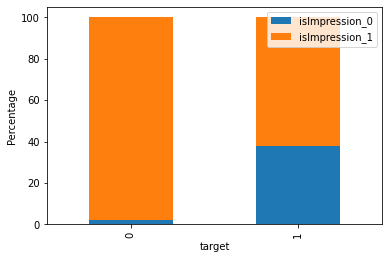

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
x_var = 'target'
groupby_var = 'isImpression'

# Group the data by target variable and count the values of dayofweek variable
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create 100% stacked bar chart
fig, ax = plt.subplots()
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)
ax.set_ylabel('Percentage')

# Name each part of the stack bar
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)

# Display the plot
plt.show()

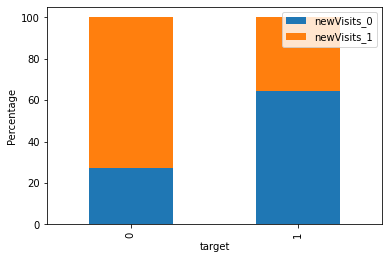

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
x_var = 'target'
groupby_var = 'newVisits'

# Group the data by target variable and count the values of dayofweek variable
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create 100% stacked bar chart
fig, ax = plt.subplots()
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)
ax.set_ylabel('Percentage')

# Name each part of the stack bar
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)

# Display the plot
plt.show()


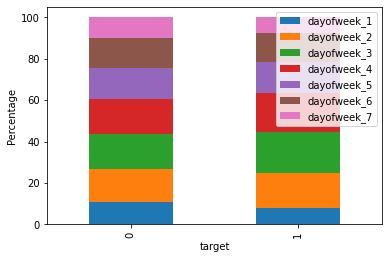

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
x_var = 'target'
groupby_var = 'dayofweek'

# Group the data by target variable and count the values of dayofweek variable
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create 100% stacked bar chart
fig, ax = plt.subplots()
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)
ax.set_ylabel('Percentage')

# Name each part of the stack bar
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)

# Display the plot
plt.show()


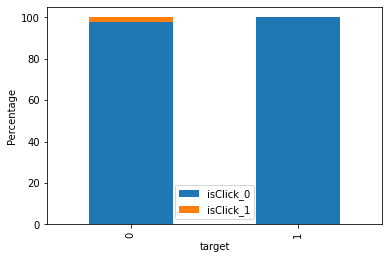

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
x_var = 'target'
groupby_var = 'isClick'

# Group the data by target variable and count the values of dayofweek variable
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create 100% stacked bar chart
fig, ax = plt.subplots()
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)
ax.set_ylabel('Percentage')

# Name each part of the stack bar
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)

# Display the plot
plt.show()


In [80]:
def plot_outliers_and_distribution(df, var, target='target'):
    """
    This function plots a boxplot to check outliers and a violin plot to see the distribution
    grouped by the target variable in one figure.
    df: pandas DataFrame
    var: str, variable/column to check
    target: str, target variable
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

    # Boxplot for outliers
    sns.boxplot(x=target, y=var, data=df, ax=axs[0])
    axs[0].set_title(f'Boxplot of {var} Grouped by {target}')

    # Violin plot for distribution
    sns.violinplot(x=target, y=var, data=df, ax=axs[1])
    axs[1].set_title(f'Violin plot of {var} Grouped by {target}')

    plt.tight_layout()
    plt.show()

# To use the function, simply call it with your DataFrame and variable:
# plot_outliers_and_distribution(df, 'timeOnSite')


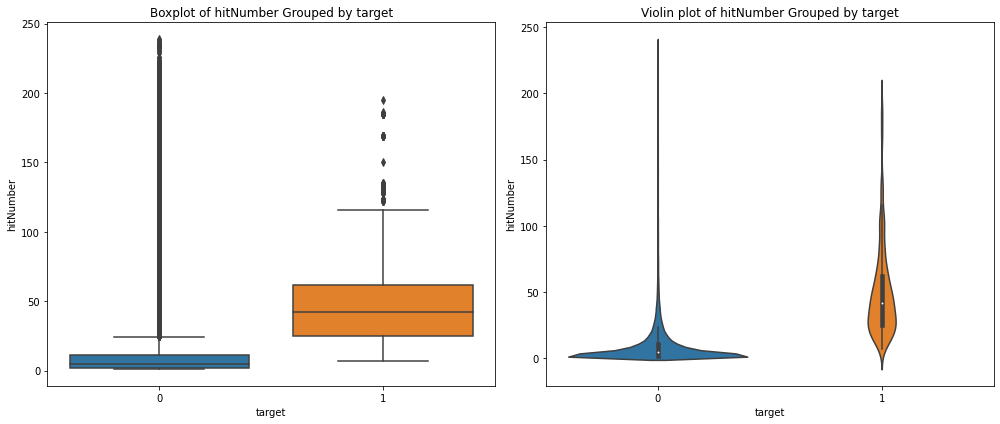

In [81]:
plot_outliers_and_distribution(df, 'hitNumber')

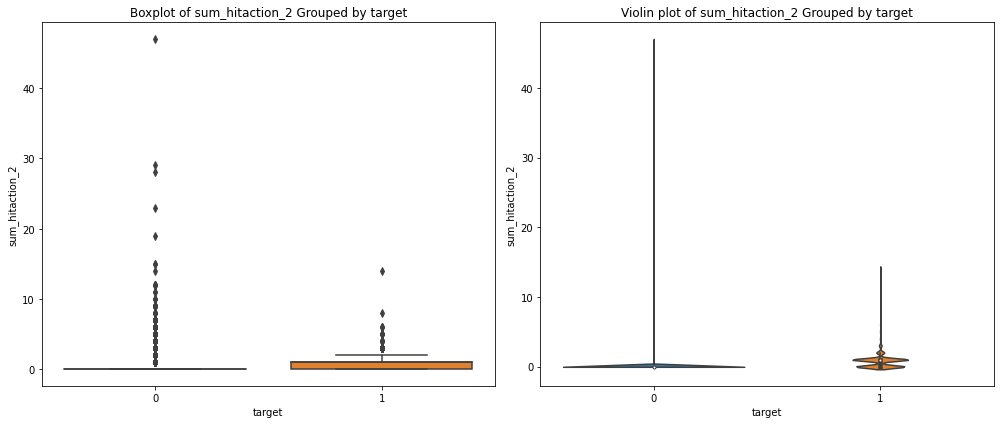

In [82]:
plot_outliers_and_distribution(df, 'sum_hitaction_2')

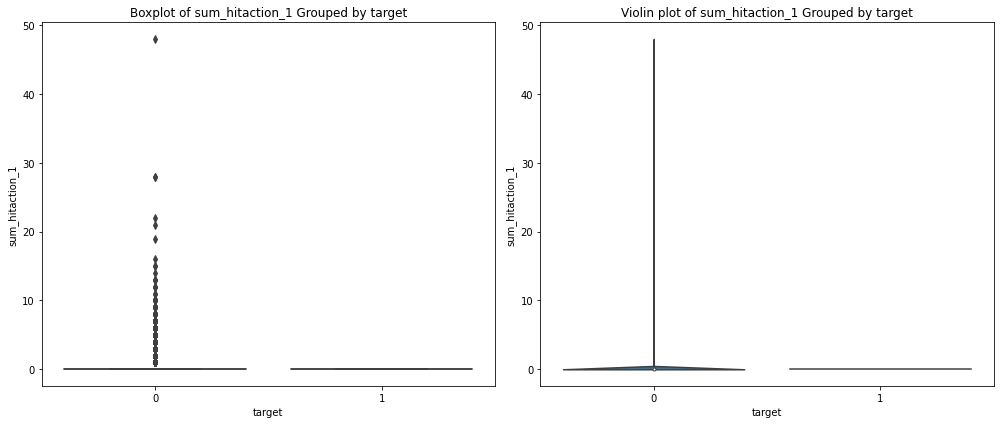

In [83]:
plot_outliers_and_distribution(df, 'sum_hitaction_1')

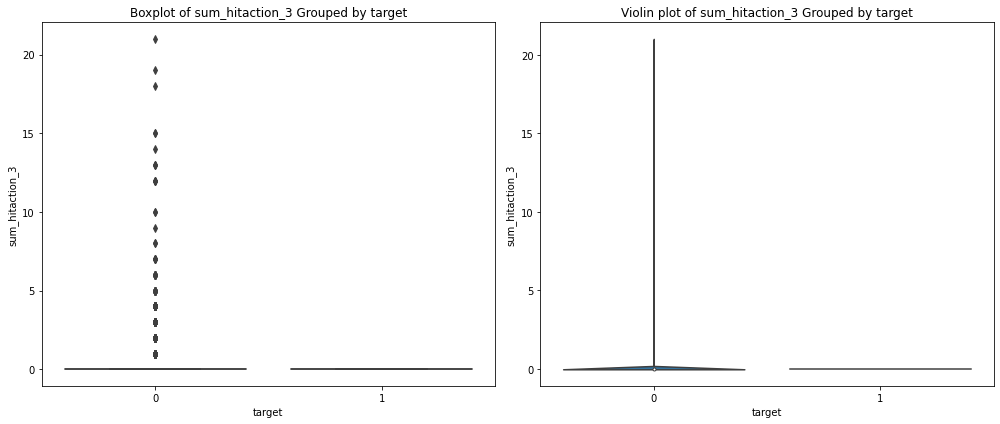

In [84]:
plot_outliers_and_distribution(df, 'sum_hitaction_3')

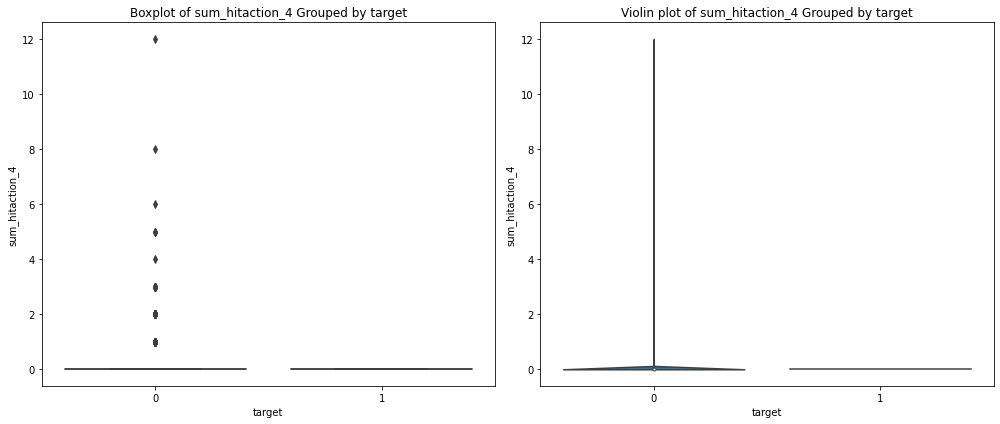

In [85]:
plot_outliers_and_distribution(df, 'sum_hitaction_4')

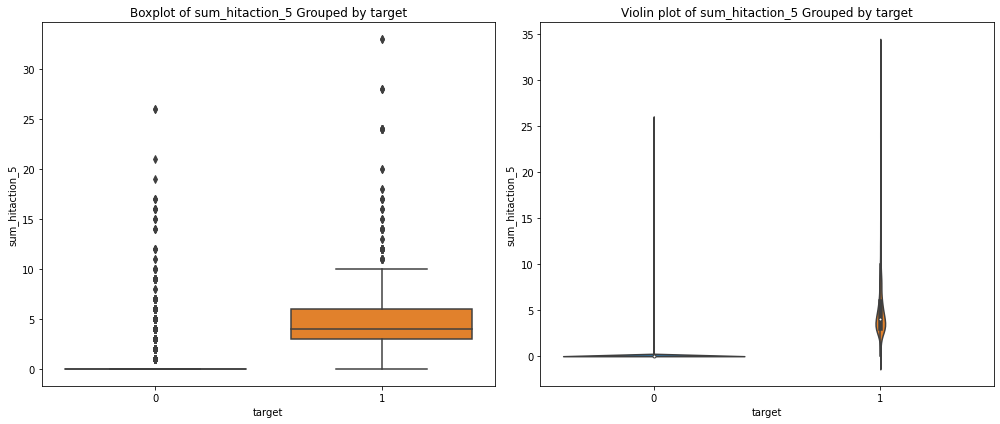

In [86]:
plot_outliers_and_distribution(df, 'sum_hitaction_5')

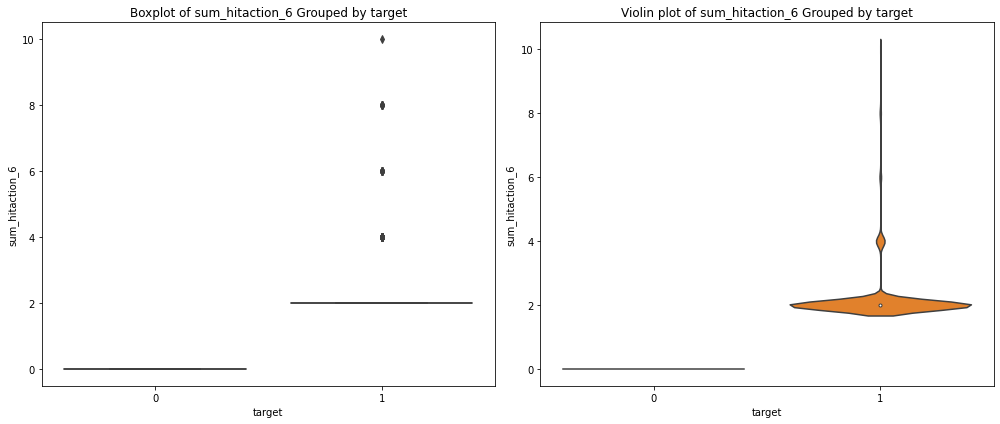

In [87]:
plot_outliers_and_distribution(df, 'sum_hitaction_6')

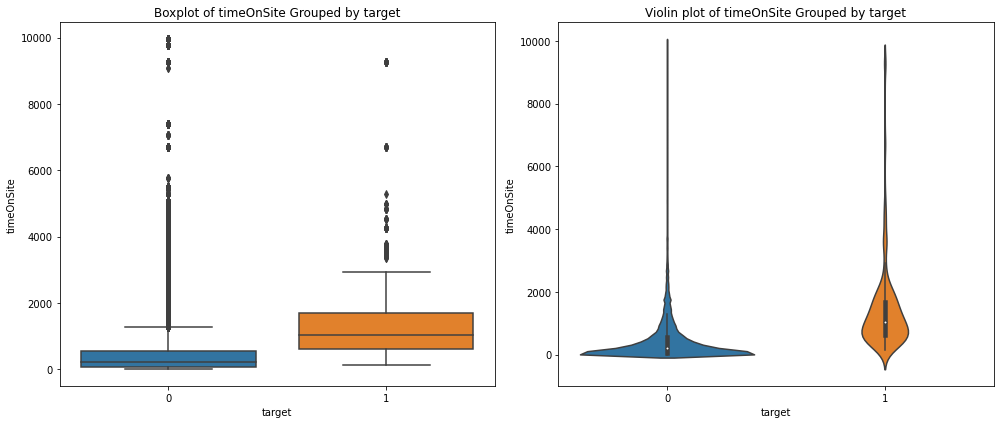

In [88]:
plot_outliers_and_distribution(df, 'timeOnSite')

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot_with_hue(dataframe, x_var, y_var, hue_var):
    # Create a new figure and set the size
    plt.figure(figsize=(10, 6))

    # Create a scatter plot with x_var on the x-axis, and y_var on the y-axis
    # Use different colors for different hue_var categories
    sns.scatterplot(x=x_var, y=y_var, hue=hue_var, data=dataframe)

    # Add labels to the x and y axes, and a title to the plot
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title('Scatter Plot of {} vs. {}, by {}'.format(x_var, y_var, hue_var))

    # Display the plot
    plt.show()


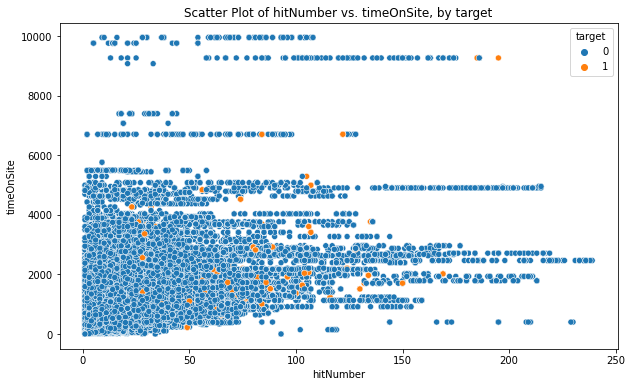

In [90]:
scatter_plot_with_hue(df, 'hitNumber', 'timeOnSite', 'target')


## Data Encoding

In [91]:
# productList_indexer = StringIndexer(inputCol='productListName', outputCol='productList_index')
# productList_ohe = OneHotEncoder(inputCol='productList_index', outputCol='productList_vec')

In [92]:
# onehot_encoder = OneHotEncoder(inputCols=['hitAction_type', 'dayofweek'], outputCols=['hitAction_type_vec', 'dayofweek_vec'])
onehot_encoder = OneHotEncoder(inputCols=['dayofweek'], outputCols=['dayofweek_vec'])

In [93]:
label_stringIdx = StringIndexer(inputCol = 'target', outputCol = 'label')

In [94]:
df3.schema.names

['fullVisitorId',
 'visitId',
 'v2ProductName',
 'isTrueDirect',
 'medium_organic',
 'dayofweek',
 'newVisits',
 'hitType_page',
 'hitHour_00_02',
 'hitHour_03_05',
 'hitHour_06_08',
 'hitHour_09_11',
 'hitHour_12_14',
 'hitHour_15_17',
 'hitHour_18_20',
 'hitHour_21_23',
 'sum_hitaction_1',
 'sum_hitaction_2',
 'sum_hitaction_3',
 'sum_hitaction_4',
 'sum_hitaction_5',
 'sum_hitaction_6',
 'hitNumber',
 'timeOnSite',
 'sessionQualityDim',
 'totalTransactionRevenue',
 'isClick',
 'isImpression',
 'target']

In [95]:
# vector_assembler = VectorAssembler\
# (inputCols = ['isTrueDirect', 'newVisits', 'hitAction_type_vec', 'hitNumber', 'isClick', 'isImpression', 'sessionQualityDim', 'timeOnSite', 'totalTransactionRevenue', \
#  'medium_organic', 'hitType_page', 'hitHour_00_02', 'hitHour_03_05', 'hitHour_06_08', 'hitHour_09_11', 'hitHour_12_14', 'hitHour_15_17', 'hitHour_18_20', \
#  'hitHour_21_23', 'hitMin_00_14', 'hitMin_15_29', 'hitMin_30_44', 'hitMin_45_60', \
#  'dayofweek_vec', 'hitAction_type_vec', 'productList_vec'], outputCol = 'features')

In [96]:
vector_assembler = VectorAssembler\
(inputCols = [\
              ###'isTrueDirect',
 ###'medium_organic',
 ###'dayofweek_vec',
 'newVisits',
 ###'hitType_page',
 ###'hitHour_00_02',
 ###'hitHour_03_05',
 ###'hitHour_06_08',
 ###'hitHour_09_11',
 ###'hitHour_12_14',
 ###'hitHour_15_17',
 ###'hitHour_18_20',
 ###'hitHour_21_23',
 ###'sum_hitaction_1',
 'sum_hitaction_2',
 ###'sum_hitaction_3',
 ###'sum_hitaction_4',
#  'sum_hitaction_5',
#  'sum_hitaction_6',
 'hitNumber',
 'timeOnSite',
 ###'sessionQualityDim',
 ###'isClick',
 'isImpression'\
 ], outputCol = 'features')

In [97]:
# pipeline = Pipeline(stages=[productList_indexer, productList_ohe, onehot_encoder, label_stringIdx, vector_assembler])
pipeline = Pipeline(stages=[onehot_encoder, label_stringIdx, vector_assembler])


In [98]:
final_df = pipeline.fit(df3).transform(df3)
final_df.show()

+-------------------+----------+--------------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+-------------+-----+--------------------+
|      fullVisitorId|   visitId|       v2ProductName|isTrueDirect|medium_organic|dayofweek|newVisits|hitType_page|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|dayofweek_vec|label|            features|
+-------------------+----------+--------------------+------------+--------------+---------

In [99]:
raw_df.count() ##Aekanun

917814

In [100]:
df3.count() ##Aekanun

636420

## Split data

In [101]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=49)
print("Training Dataset: " + str(train_df.count()))
print("Test Dataset: " + str(test_df.count()))

Training Dataset: 509123


Test Dataset: 127297


In [102]:
train_df.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|507680|
|  1.0|  1443|
+-----+------+



In [103]:
test_df.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|126942|
|  1.0|   355|
+-----+------+



## Oversampling

In [104]:
balanceRatio = train_df.filter(sparkf.col('label') == 1).count() / train_df.count()

In [105]:
balanceRatio

0.002834285624495456

In [106]:
calWeight = sparkf.udf(lambda x: 1 * balanceRatio if x == 0 else (1 * (1.0 - balanceRatio)), DoubleType())

In [107]:
weighted_df = train_df.withColumn('class_weight', calWeight('label'))

# 4. Modeling

In [108]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features', weightCol='class_weight', seed=49)

In [109]:
rfModel = rf.fit(weighted_df)

In [110]:
result_df = rfModel.transform(test_df.dropna())

In [111]:
result_df.select(['label', 'prediction']).filter(result_df.label == 1).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



In [112]:
result_df.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|124074|
|       1.0|  3223|
+----------+------+



In [113]:
result_df.groupBy('label','prediction').count().show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0|   341|
|  0.0|       1.0|  2882|
|  1.0|       0.0|    14|
|  0.0|       0.0|124060|
+-----+----------+------+



In [114]:
featureImportances = rfModel.featureImportances.toArray()

In [115]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [116]:
ExtractFeatureImp(featureImportances, result_df, "features").head(30)

,idx,name,score
2,2,hitNumber,0.589396
4,4,isImpression,0.209667
1,1,sum_hitaction_2,0.125666
3,3,timeOnSite,0.063312
0,0,newVisits,0.011958


In [117]:
rfModel.getNumTrees

20

# 5. Evaluation

In [118]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_df))

Area Under ROC = 0.96893


In [119]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')
print('F1 score = %g' % evaluator.evaluate(result_df))
print('Precision = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'precisionByLabel'}))
print('Recall = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'recallByLabel'}))

F1 score = 0.986238


Precision = 0.999887


Recall = 0.977297


## Tuning

In [120]:
paramGrid = ParamGridBuilder() \
.addGrid(rf.numTrees, [20, 50, 100]) \
.build()

In [121]:
crossval = CrossValidator(estimator=rf, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=BinaryClassificationEvaluator(), 
                          numFolds=5)

In [122]:
cvModel = crossval.fit(weighted_df)

In [123]:
result_cv_df = cvModel.transform(test_df.dropna())

In [124]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_cv_df))

Area Under ROC = 0.967494


# 6. Deployment

REST API